# LSTM Utilization Prediction

This Jupyter Notebook is aimed to test, if the utilization of hardware can be predicted by its historical utilization.
For this, a Long-Short Term Memory (LSTM) Neural Networks are used.

These are a special kind of Recurrent Neural Networks (RNN), which are capable of learning long-term dependencies.
This property fits our use case of trying to predict a future sequential time-series based on a past sequential time-series.


## Resources 

- This notebook relied on the sources:
  -  [How to apply LSTM using PyTorch](https://cnvrg.io/pytorch-lstm/) and
  -  [Predicting-cloud-CPU-usage-on-Azure-data](https://github.com/amcs1729/Predicting-cloud-CPU-usage-on-Azure-data).
- [Further Reading on LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

## Importing the Python Modules

*Note: If you encounter an error while trying to load the modules, go to the README.md for installing infos*

In [31]:
# used for statistical processes, i.e scaling the dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# plotting the data
import matplotlib.pyplot as plt
# used for the dataframes
import pandas as pd
# transforming dataframes into arrays
# and those arrays to Tensors, the ML approach can work with
import numpy as np
%matplotlib inline

# required for the LSTM model
import torch
import torch.nn as nn
from torch.autograd import Variable

## Loading the Dataframe

In this cell the dataframe with the machine utilization data will be loaded and prepared if necessary.

In [32]:
df = pd.read_csv('training_machine_sorted_df.csv')
df['timestamp'] = pd.to_datetime(df['start_date'])
df = df.set_index('timestamp')
# df = df.sort_index()
df.drop(columns=['start_date'], inplace=True)
df.head()

,machine,job_name,task_name,inst_num,cpu_usage,gpu_wrk_util,avg_mem,max_mem,avg_gpu_wrk_mem,max_gpu_wrk_mem,gpu_type,runtime
timestamp,,,,,,,,,,,,
1970-01-28 15:32:43+08:00,0018d759f400ef5c0457ab9c,9d28a91e7301a697bad12557,worker,4.0,35.636364,0.080000,2.060832,32.796875,2.447969,4.208984,V100,114.0
1970-01-29 16:01:19+08:00,0018d759f400ef5c0457ab9c,74474bd870f2447ac939f9cd,worker,20.0,51.043478,13.692308,0.780721,1.835938,0.441632,0.993164,V100,104.0
1970-01-29 16:05:16+08:00,0018d759f400ef5c0457ab9c,a75f2d5a26b8fff5724fdd6d,PyTorchWorker,1.0,59.483871,24.029412,3.403646,37.934570,2.487621,6.723633,V100,161.0
1970-01-30 11:54:59+08:00,0018d759f400ef5c0457ab9c,0be403d9f0299123cb12c498,PyTorchWorker,1.0,8021.102453,77.019231,4.084847,37.093750,6.160750,6.541992,V100,10397.0
1970-01-30 14:50:21+08:00,0018d759f400ef5c0457ab9c,a23b5d2cf2a5c94a8a798ac7,PyTorchWorker,1.0,81.285714,42.958333,4.360521,37.631836,3.374715,6.723633,V100,114.0


In [33]:
df.groupby('machine').count()

df = df.query("machine == 'ffb1bc4dc2fbb09d0477f0f0'")
df = df.drop(columns=['machine', 'gpu_type', 'job_name'])
df

,task_name,inst_num,cpu_usage,gpu_wrk_util,avg_mem,max_mem,avg_gpu_wrk_mem,max_gpu_wrk_mem,runtime
timestamp,,,,,,,,,
1970-01-22 20:07:16+08:00,worker,10.0,821.293854,98.348452,20.059473,20.153320,8.268555,8.268555,373460.0
1970-01-25 20:53:01+08:00,worker,40.0,60.262069,3.033012,4.192815,4.218750,3.416992,3.416992,14832.0
1970-01-25 22:55:27+08:00,PyTorchWorker,1.0,122.976702,32.901065,4.136477,4.647461,5.032227,5.032227,31543.0
1970-01-25 22:55:28+08:00,PyTorchWorker,1.0,122.983868,32.782827,4.128471,4.654297,5.030273,5.030273,27720.0
1970-01-25 22:55:28+08:00,PyTorchWorker,1.0,122.745224,32.372354,4.125382,4.626953,4.692383,4.692383,27939.0
...,...,...,...,...,...,...,...,...,...
1970-03-16 21:53:19+08:00,worker,20.0,1010.226519,18.305556,7.961008,10.300781,2.179438,2.327148,1793.0
1970-03-16 22:20:23+08:00,worker,20.0,241.318182,10.545455,8.127752,11.995117,4.773659,7.370117,206.0
1970-03-16 22:28:33+08:00,PyTorchWorker,1.0,6178.964143,33.330677,2.107500,2.178711,1.793004,1.836914,2495.0


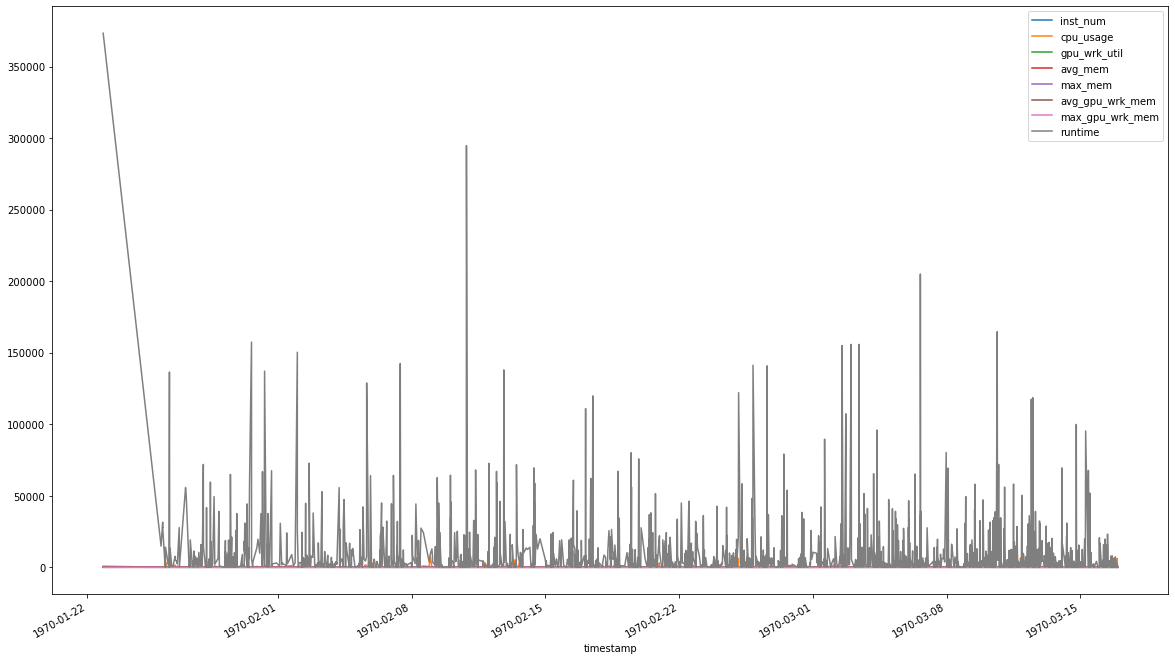

In [5]:
df.plot(figsize=(20, 12))
plt.show()

## Add One-Hot Encoded Columns for Taskname

In order to process categorical data, in this case the `task_name` column, we need to encode it.

For this, we use the `pandas.get_dummies()` method that returns the `task_name` column as one-hot encoded columns.

In [34]:
dummies = pd.get_dummies(df.task_name)
dummies

,OpenmpiWorker,OssToVolumeWorker,PyTorchWorker,tensorflow,worker
timestamp,,,,,
1970-01-22 20:07:16+08:00,0,0,0,0,1
1970-01-25 20:53:01+08:00,0,0,0,0,1
1970-01-25 22:55:27+08:00,0,0,1,0,0
1970-01-25 22:55:28+08:00,0,0,1,0,0
1970-01-25 22:55:28+08:00,0,0,1,0,0
...,...,...,...,...,...
1970-03-16 21:53:19+08:00,0,0,0,0,1
1970-03-16 22:20:23+08:00,0,0,0,0,1
1970-03-16 22:28:33+08:00,0,0,1,0,0


### Add the One-Hot Encoded Columns

After generating the one-hot encoded columns for `task_name`, we append it to the dataframe.
Afterwards, we remove the `task_name` column since it is now represented by those appended columns.

In [35]:
df = df.join(dummies)
df.drop(columns=['task_name'], inplace=True)
df

,inst_num,cpu_usage,gpu_wrk_util,avg_mem,max_mem,avg_gpu_wrk_mem,max_gpu_wrk_mem,runtime,OpenmpiWorker,OssToVolumeWorker,PyTorchWorker,tensorflow,worker
timestamp,,,,,,,,,,,,,
1970-01-22 20:07:16+08:00,10.0,821.293854,98.348452,20.059473,20.153320,8.268555,8.268555,373460.0,0,0,0,0,1
1970-01-25 20:53:01+08:00,40.0,60.262069,3.033012,4.192815,4.218750,3.416992,3.416992,14832.0,0,0,0,0,1
1970-01-25 22:55:27+08:00,1.0,122.976702,32.901065,4.136477,4.647461,5.032227,5.032227,31543.0,0,0,1,0,0
1970-01-25 22:55:28+08:00,1.0,122.983868,32.782827,4.128471,4.654297,5.030273,5.030273,27720.0,0,0,1,0,0
1970-01-25 22:55:28+08:00,1.0,122.983868,32.782827,4.128471,4.654297,5.030273,5.030273,27720.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-03-16 21:53:19+08:00,20.0,1010.226519,18.305556,7.961008,10.300781,2.179438,2.327148,1793.0,0,0,0,0,1
1970-03-16 22:20:23+08:00,20.0,241.318182,10.545455,8.127752,11.995117,4.773659,7.370117,206.0,0,0,0,0,1
1970-03-16 22:28:33+08:00,1.0,6178.964143,33.330677,2.107500,2.178711,1.793004,1.836914,2495.0,0,0,1,0,0


## Splitting the Dataframe into Train and Testset

In [36]:
TRAIN_LENGTH = round(len(df) * 0.8)
TEST_LENGTH = len(df) - TRAIN_LENGTH
train = df.iloc[0:TRAIN_LENGTH]
test = df[TRAIN_LENGTH:]

## Scaling the Datasets

In this step the train and test datasets are scaled to represent the data values in a (-1, 1) interval.
This is done to omit unwanted behaviour by the machine learning model. 

[Code Source](https://cnvrg.io/pytorch-lstm/)

In [37]:
mm_scaler = MinMaxScaler()
ss_scaler = StandardScaler()
X_ss = pd.DataFrame(ss_scaler.fit_transform(train))
y_mm = pd.DataFrame(mm_scaler.fit_transform(test))
# y_mm = pd.DataFrame(mm_scaler.fit_transform(test))

## Split the Dataset

Now the dataset gets split into test and training dataset.

*Note: To later be able to convert the dataset into Tensors, it is necessary to convert them to numpy arrays via `.to_numpy()`*.

In [38]:
TRAIN_SPLIT: int = 450
TEST_SPLIT = TRAIN_SPLIT + 100

X_train = X_ss[:TRAIN_SPLIT].to_numpy()
X_test = X_ss[TRAIN_SPLIT:TEST_SPLIT].to_numpy()

y_train = y_mm[:TRAIN_SPLIT].to_numpy()
y_test = y_mm[TRAIN_SPLIT:TEST_SPLIT].to_numpy()

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (450, 13) (450, 13)
Testing Shape (100, 13) (100, 13)


## Converting the Datasets to Tensors

In order to be able to use the datasets with PyTorch, we first have to convert them to Tensors.

In [41]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_range = [num for num in range(7)]
y_train_trimmed = y_train[:, y_range]
y_test_trimmed = y_test[:, y_range]

y_train_tensors = Variable(torch.Tensor(y_train_trimmed))
y_test_tensors = Variable(torch.Tensor(y_test_trimmed))
y_train_tensors.shape

torch.Size([450, 7])

## Reshaping to Rows, Timestamps and Features

In the reshaping process, we add an additional dimension.

This is done, because LSTMs are built for sequential data and cannot "comprehend" simple 2-D data as its input.
They need to also have the timestamp information with them, so they can work properly.

In [42]:
# Reshaping
X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([450, 1, 13]) torch.Size([450, 7])
Testing Shape torch.Size([100, 1, 13]) torch.Size([100, 7])


## Create the LSTM Model



In [43]:
class LSTM(nn.Module):

    def __init__(self, num_classes: int, input_size: int, hidden_size: int, num_layers: int, seq_length: int) -> None:
        super(LSTM, self).__init__()
        self.num_classes: int = num_classes
        self.input_size: int = input_size
        self.hidden_size: int = hidden_size
        self.num_layers: int = num_layers
        self.seq_length: int = seq_length

        # long-short term memory layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True)

        # first fully connected layer
        self.fc_1 = nn.Linear(hidden_size, 128)
        # second fully connected layer
        self.fc_2 = nn.Linear(128, num_classes)
        # activation function
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden_state = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
        internal_state = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(input, (hidden_state, internal_state))
        # Reshaping the data for the Dense layer
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc_2(out)
        
        return out
    

## Defining some hyperparameters

In the following cell, some hyperparameters are defined for further usage.

In [48]:
num_epochs: int = 300
learning_rate: float = 0.005

# number of features
input_size: int = len(train.columns)
# number of features in hidden state
hidden_size: int = 2
# number of stacked lstm layers
num_layers: int = 1
# number of output classes
num_classes: int = len(y_range)

## Instantiate the LSTM object

In [49]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1])

## Define the Loss Function and Optimizer

In [50]:
# mean squared error for regression
criterion = nn.MSELoss()
# optimizer function
optimizer = torch.optim.AdamW(lstm.parameters(), lr=learning_rate)

## Training Loop

In the following, the training of the LSTM model is done.

In [51]:
for epoch in range(num_epochs):
    # forward pass
    outputs = lstm.forward(X_train_tensors_final)
    # calculates the gradient and manually setting to 0
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)

    # calculates the loss of the loss function
    loss.backward()

    # improve from loss, i.e backpropagation
    optimizer.step()  
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


Epoch: 0, loss: 0.09020
Epoch: 100, loss: 0.02638
Epoch: 200, loss: 0.02507


In [61]:
# old transformers
df_X_ss = ss_scaler.transform(df)
df_y_mm = mm_scaler.transform(df)

# converting to Tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))

# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))


/Users/macbook/opt/miniconda3/envs/ml_pytorch/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


ValueError: X has 13 features, but StandardScaler is expecting 7 features as input.

In [54]:
# Evaluation Mode
lstm.eval()

# forward pass
train_predict = lstm(df_X_ss)
data_predict = train_predict.data.numpy()
data_predict = ss_scaler.fit_transform(data_predict)

dataY_plot = df_y_mm.data.numpy()
# dataY_plot = mm_scaler.fit_transform(dataY_plot)

# reverse transformation
data_predict = ss_scaler.inverse_transform(data_predict)  
dataY_plot = mm_scaler.inverse_transform(dataY_plot)

In [59]:
print(dataY_plot.shape)
data_predict_df = pd.DataFrame(data_predict, columns=df.columns[:7])
data_y_plot_df = pd.DataFrame(dataY_plot, columns=df.columns[:7])

(3123, 13)


ValueError: Shape of passed values is (3123, 13), indices imply (3123, 7)

In [ ]:
plt.figure(figsize=(25, 15))  # plotting
# plt.axvline(x=TRAIN_SPLIT, c='r', linestyle='--')  # size of the training set
pred_colums = ['pred_' + col for col in df.columns]

column = df.columns[0]

plt.plot(data_y_plot_df[column], label=column)  # actual plot
plt.plot(data_predict_df[column], label='pred_' + column)  # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(25, 15))  # plotting
pred_colums = ['pred_' + col for col in df.columns]

column = df.columns[1]

plt.plot(data_y_plot_df[column], label=column)  # actual plot
plt.plot(data_predict_df[column], label='pred_' + column)  # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(25, 15))  # plotting
pred_colums = ['pred_' + col for col in df.columns]

column = df.columns[2]

plt.plot(data_y_plot_df[column], label=column)  # actual plot
plt.plot(data_predict_df[column], label='pred_' + column)  # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(25, 15))  # plotting
pred_colums = ['pred_' + col for col in df.columns]

column = df.columns[4]

plt.plot(data_y_plot_df[column], label=column)  # actual plot
plt.plot(data_predict_df[column], label='pred_' + column)  # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(25, 15))  # plotting
pred_colums = ['pred_' + col for col in df.columns]

column = df.columns[5]

plt.plot(data_y_plot_df[column], label=column)  # actual plot
plt.plot(data_predict_df[column], label='pred_' + column)  # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(25, 15))  # plotting
pred_colums = ['pred_' + col for col in df.columns]

column = df.columns[6]

plt.plot(data_y_plot_df[column], label=column)  # actual plot
plt.plot(data_predict_df[column], label='pred_' + column)  # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

### Root Mean Squared Error (RMSE)

$\operatorname{RMSD}(\hat{\theta}) = \sqrt{\operatorname{MSE}(\hat{\theta})} = \sqrt{\operatorname{E}((\hat{\theta}-\theta)^2)}$

In [ ]:
import math

In [ ]:
rmse_result = math.sqrt(mean_squared_error(dataY_plot[:], data_predict_df[:]))
print(f'Test Score: {rmse_result:.2f} RMSE')

### Mean Absolute Error (MAE)

$\mathrm {MAE} ={\frac {\sum _{i=1}^{n}\left|y_{i}-x_{i}\right|}{n}}={\frac {\sum _{i=1}^{n}\left|e_{i}\right|}{n}}
$

In [ ]:
mae_result = mean_absolute_error(dataY_plot[:], data_predict_df[:])
print(f'Test Score: {mae_result} MAE')

### Mean Absolute Percentage Error (MAPE)

$MAPE={\frac {100\%}{n}}\sum _{t=1}^{n}\left|{\frac {A_{t}-F_{t}}{A_{t}}}\right|$

The **mean absolute percentage error (MAPE)**, is a measure of prediction accuracy of a forecasting (prediction) method in statistics.

$A_t$ is the actual value and $F_t$ is the predicted value. Their difference is divided by the actual value $A_t$. 

The absolute value in this ration is summed for every predicted point in time and divided by the number of fitted points $n$.

In [ ]:
mape_result = np.mean(np.abs(dataY_plot - data_predict_df)/np.abs(dataY_plot)*100)
print(f'Test Score: {mape_result} MAPE')